<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

import torch.distributions

# Latent dimensions
z = 10
# Training iterations
iter_max =50 #200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader,test_loader, (X_test, y_test)

train_loader, _,_ = get_mnist_data(device, batch_size)
_,test_loader,_ = get_mnist_data(device, batch_size)
_,_,(X_test, y_test)=get_mnist_data(device, batch_size)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    #Sample z
    N=torch.distributions.Normal(0, 1)
    N.loc = N.loc.cuda()
    N.scale = N.scale.cuda()
    z = m + torch.sqrt(v)*N.sample(m.shape)
    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


In [ ]:


class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2, Beta=1):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.Beta=Beta

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        # Computing negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        m, v = self.enc.encode(x)
        kl= kl_normal(m,v,pm=torch.zeros(1).expand(self.z_dim).cuda(),pv=torch.ones(1).expand(self.z_dim).cuda())*self.Beta
        kl=torch.mean(kl)
        z = sample_gaussian(m, v)
        logits= self.dec.decode(z)
        rec= -log_bernoulli_with_logits(x, logits)
        rec=torch.mean(rec)
        nelbo= kl+rec
        return nelbo, kl, rec


    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))
        return loss, summaries


    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


# Regular VAE(Beta=1)

In [ ]:

vae_1 = VAE(z_dim=z,Beta=1).to(device)
optimizer = optim.Adam(vae_1.parameters(), lr=learning_rate)
nelbo_1=torch.zeros(1,50)
kl_1=torch.zeros(1,50)
rec_1=torch.zeros(1,50)
nelbo_test_1=torch.zeros(1,50)
kl_test_1=torch.zeros(1,50)
rec_test_1=torch.zeros(1,50)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae_1.loss(xu)
        nelbo_1[0][i]=loss
        kl_1[0][i]=summaries['gen/kl_z']
        rec_1[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = vae_1.loss(xu_test)

        nelbo_test_1[0][i]=loss_test
        kl_test_1[0][i]=summaries_test['gen/kl_z']
        rec_test_1[0][i]=summaries_test['gen/rec']


  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(124.6441, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(14.6927, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(109.9513, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:10<08:34, 10.50s/it]

nelbo:  tensor(119.4015, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.2297, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(102.1719, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:18<07:14,  9.05s/it]

nelbo:  tensor(117.4661, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.4036, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(100.0625, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:28<07:22,  9.41s/it]

nelbo:  tensor(109.0346, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.3757, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(91.6589, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:38<07:24,  9.66s/it]

nelbo:  tensor(107.9494, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.6334, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(90.3160, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:47<07:13,  9.63s/it]

nelbo:  tensor(107.9089, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.0914, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(89.8176, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:57<07:00,  9.57s/it]

nelbo:  tensor(108.1567, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.8942, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(89.2625, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [01:06<06:51,  9.56s/it]

nelbo:  tensor(98.7700, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.0415, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.7285, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:16<06:41,  9.56s/it]

nelbo:  tensor(102.6406, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.4152, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(84.2254, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:24<06:13,  9.11s/it]

nelbo:  tensor(107.8256, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.8535, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.9721, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:33<05:57,  8.93s/it]

nelbo:  tensor(107.3887, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.4987, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.8900, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:42<05:48,  8.94s/it]

nelbo:  tensor(104.8963, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7605, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(86.1359, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:51<05:46,  9.12s/it]

nelbo:  tensor(106.8319, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0580, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(87.7739, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [02:02<05:54,  9.58s/it]

nelbo:  tensor(102.8831, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0862, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.7970, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [02:11<05:37,  9.37s/it]

nelbo:  tensor(108.8033, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9093, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(89.8940, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:23<05:58, 10.24s/it]

nelbo:  tensor(96.0398, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.2768, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.7630, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:31<05:27,  9.64s/it]

nelbo:  tensor(102.6086, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0677, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.5409, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:42<05:24,  9.84s/it]

nelbo:  tensor(98.2562, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.2694, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.9868, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:51<05:10,  9.69s/it]

nelbo:  tensor(102.4578, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.5700, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.8878, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [03:04<05:34, 10.78s/it]

nelbo:  tensor(104.1359, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0440, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.0918, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [03:12<05:00, 10.00s/it]

nelbo:  tensor(107.6071, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3423, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.2648, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [03:26<05:21, 11.10s/it]

nelbo:  tensor(101.3462, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0551, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.2911, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:36<04:57, 10.64s/it]

nelbo:  tensor(101.1396, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4070, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.7326, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:45<04:38, 10.33s/it]

nelbo:  tensor(98.0816, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.8244, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.2572, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:53<04:11,  9.67s/it]

nelbo:  tensor(101.9357, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3929, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.5428, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [04:01<03:49,  9.19s/it]

nelbo:  tensor(102.6841, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3893, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.2948, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [04:09<03:32,  8.86s/it]

nelbo:  tensor(100.1668, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1096, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.0571, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [04:18<03:18,  8.63s/it]

nelbo:  tensor(95.1029, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0435, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.0593, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [04:26<03:06,  8.48s/it]

nelbo:  tensor(101.5536, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9461, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.6075, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [04:34<02:55,  8.34s/it]

nelbo:  tensor(95.6595, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1624, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.4971, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:42<02:49,  8.46s/it]

nelbo:  tensor(101.1077, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.8676, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.2401, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:51<02:38,  8.34s/it]

nelbo:  tensor(99.2677, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7838, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.4839, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:59<02:28,  8.25s/it]

nelbo:  tensor(95.2075, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7491, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.4583, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [05:07<02:22,  8.39s/it]

nelbo:  tensor(99.7099, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1289, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.5809, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [05:15<02:12,  8.27s/it]

nelbo:  tensor(102.7448, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4887, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.2561, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [05:23<02:02,  8.19s/it]

nelbo:  tensor(99.2103, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(20.1206, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.0897, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [05:32<01:56,  8.35s/it]

nelbo:  tensor(99.7764, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4568, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.3196, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:40<01:48,  8.32s/it]

nelbo:  tensor(96.2140, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3541, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.8599, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:48<01:39,  8.28s/it]

nelbo:  tensor(98.8367, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6602, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.1766, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:56<01:30,  8.19s/it]

nelbo:  tensor(101.5108, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.7377, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.7731, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [06:04<01:21,  8.16s/it]

nelbo:  tensor(100.8035, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.8236, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.9799, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [06:13<01:13,  8.15s/it]

nelbo:  tensor(92.1654, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.8705, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.2949, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [06:21<01:05,  8.14s/it]

nelbo:  tensor(98.0369, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4303, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.6066, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [06:29<00:56,  8.13s/it]

nelbo:  tensor(101.3821, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5397, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.8424, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [06:37<00:48,  8.08s/it]

nelbo:  tensor(98.8316, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5723, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.2594, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:51<00:49,  9.99s/it]

nelbo:  tensor(97.7907, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.7905, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.0003, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [06:59<00:37,  9.39s/it]

nelbo:  tensor(95.1155, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5383, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.5773, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [07:07<00:26,  8.97s/it]

nelbo:  tensor(97.3408, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6866, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.6543, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [07:15<00:17,  8.71s/it]

nelbo:  tensor(98.2606, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3807, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.8799, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [07:23<00:08,  8.48s/it]

nelbo:  tensor(90.5771, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.2336, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(71.3435, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [07:31<00:00,  9.04s/it]


# BVAE(Beta=0.1)

In [ ]:

vae_04 = VAE(z_dim=z,Beta=0.1).to(device)
optimizer = optim.Adam(vae_04.parameters(), lr=learning_rate)
nelbo_04=torch.zeros(1,50)
kl_04=torch.zeros(1,50)
rec_04=torch.zeros(1,50)
nelbo_test_04=torch.zeros(1,50)
kl_test_04=torch.zeros(1,50)
rec_test_04=torch.zeros(1,50)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae_04.loss(xu)
        nelbo_04[0][i]=loss
        kl_04[0][i]=summaries['gen/kl_z']
        rec_04[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = vae_04.loss(xu_test)
        nelbo_test_04[0][i]=loss_test
        kl_test_04[0][i]=summaries_test['gen/kl_z']
        rec_test_04[0][i]=summaries_test['gen/rec']



  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(102.8490, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3020, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(99.5470, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:08<06:58,  8.54s/it]

nelbo:  tensor(98.5320, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3026, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(95.2294, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:16<06:34,  8.22s/it]

nelbo:  tensor(95.0228, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.2736, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(91.7493, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:24<06:21,  8.13s/it]

nelbo:  tensor(91.7370, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3535, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.3834, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:32<06:12,  8.10s/it]

nelbo:  tensor(84.0694, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3389, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.7305, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:40<06:02,  8.06s/it]

nelbo:  tensor(89.8845, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3373, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(86.5472, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:48<05:54,  8.06s/it]

nelbo:  tensor(85.6554, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4169, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.2384, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [00:56<05:49,  8.12s/it]

nelbo:  tensor(84.5388, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3353, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.2035, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:07<06:11,  8.84s/it]

nelbo:  tensor(82.2439, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3534, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.8905, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:15<05:53,  8.62s/it]

nelbo:  tensor(80.0532, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3670, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.6862, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:24<05:47,  8.70s/it]

nelbo:  tensor(81.1738, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4194, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.7544, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:32<05:38,  8.68s/it]

nelbo:  tensor(81.2329, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3386, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.8943, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:40<05:22,  8.49s/it]

nelbo:  tensor(81.7631, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3918, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.3713, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [01:49<05:10,  8.38s/it]

nelbo:  tensor(77.0262, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3876, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.6386, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [01:57<04:58,  8.30s/it]

nelbo:  tensor(76.4706, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3694, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.1012, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:05<04:49,  8.27s/it]

nelbo:  tensor(77.3583, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4534, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.9049, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:13<04:40,  8.25s/it]

nelbo:  tensor(78.1946, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3885, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.8061, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:22<04:38,  8.43s/it]

nelbo:  tensor(76.3689, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4115, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(72.9574, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:30<04:26,  8.34s/it]

nelbo:  tensor(77.8269, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4474, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.3795, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [02:38<04:16,  8.29s/it]

nelbo:  tensor(78.9733, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3517, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.6217, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [02:46<04:07,  8.25s/it]

nelbo:  tensor(78.9694, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4329, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.5365, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [02:55<03:57,  8.21s/it]

nelbo:  tensor(80.1871, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4518, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.7352, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:03<03:48,  8.17s/it]

nelbo:  tensor(78.6001, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3959, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.2042, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:11<03:41,  8.22s/it]

nelbo:  tensor(76.0897, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4418, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(72.6479, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:19<03:31,  8.15s/it]

nelbo:  tensor(76.0655, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4563, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(72.6092, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [03:27<03:23,  8.13s/it]

nelbo:  tensor(77.9253, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4546, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.4707, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [03:35<03:16,  8.20s/it]

nelbo:  tensor(79.5732, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4644, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.1088, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [03:43<03:07,  8.14s/it]

nelbo:  tensor(80.0018, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3543, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.6476, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [03:51<02:58,  8.11s/it]

nelbo:  tensor(76.5431, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3763, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.1668, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [03:59<02:49,  8.07s/it]

nelbo:  tensor(74.7862, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4792, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(71.3070, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:07<02:40,  8.04s/it]

nelbo:  tensor(73.6089, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3283, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(70.2806, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:15<02:32,  8.04s/it]

nelbo:  tensor(76.1395, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3714, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(72.7681, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:24<02:25,  8.08s/it]

nelbo:  tensor(79.3921, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3977, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.9944, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [04:32<02:17,  8.11s/it]

nelbo:  tensor(82.8992, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4819, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.4173, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [04:40<02:09,  8.07s/it]

nelbo:  tensor(79.3712, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3766, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.9946, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [04:48<02:00,  8.04s/it]

nelbo:  tensor(70.9682, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4060, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(67.5622, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [04:58<02:00,  8.64s/it]

nelbo:  tensor(82.7397, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4591, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.2806, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:07<01:55,  8.91s/it]

nelbo:  tensor(77.9944, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4676, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.5268, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:15<01:43,  8.65s/it]

nelbo:  tensor(80.1274, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.5100, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.6174, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:24<01:33,  8.51s/it]

nelbo:  tensor(76.1536, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4522, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(72.7014, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [05:31<01:23,  8.35s/it]

nelbo:  tensor(78.4304, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4259, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.0045, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [05:39<01:14,  8.23s/it]

nelbo:  tensor(74.4438, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4377, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(71.0061, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [05:47<01:05,  8.15s/it]

nelbo:  tensor(74.5022, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4459, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(71.0563, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [05:55<00:56,  8.11s/it]

nelbo:  tensor(69.3943, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3320, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(66.0623, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [06:03<00:48,  8.06s/it]

nelbo:  tensor(70.8959, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4026, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(67.4934, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:11<00:40,  8.03s/it]

nelbo:  tensor(78.4638, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4119, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.0519, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [06:20<00:32,  8.21s/it]

nelbo:  tensor(80.1626, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4238, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.7388, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [06:28<00:24,  8.15s/it]

nelbo:  tensor(73.6661, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3678, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(70.2983, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [06:36<00:16,  8.10s/it]

nelbo:  tensor(75.0760, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.4282, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(71.6477, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [06:45<00:08,  8.34s/it]

nelbo:  tensor(76.9363, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(3.3661, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(73.5701, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [06:53<00:00,  8.27s/it]


# BVAE(Beta=10)

In [ ]:
vae_10 = VAE(z_dim=z,Beta=10).to(device)
optimizer = optim.Adam(vae_10.parameters(), lr=learning_rate)
nelbo_10=torch.zeros(1,50)
kl_10=torch.zeros(1,50)
rec_10=torch.zeros(1,50)
nelbo_test_10=torch.zeros(1,50)
kl_test_10=torch.zeros(1,50)
rec_test_10=torch.zeros(1,50)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae_10.loss(xu)
        nelbo_10[0][i]=loss
        kl_10[0][i]=summaries['gen/kl_z']
        rec_10[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = vae_10.loss(xu_test)
        nelbo_test_10[0][i]=loss_test
        kl_test_10[0][i]=summaries_test['gen/kl_z']
        rec_test_10[0][i]=summaries_test['gen/rec']


  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(193.4899, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(20.6748, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(172.8152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:10<08:10, 10.01s/it]

nelbo:  tensor(186.3911, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(26.2416, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(160.1495, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:18<07:05,  8.87s/it]

nelbo:  tensor(183.3367, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(27.8794, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(155.4572, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:26<06:45,  8.63s/it]

nelbo:  tensor(184.4988, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(31.2099, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(153.2889, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:38<07:31,  9.82s/it]

nelbo:  tensor(179.4369, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(30.3449, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(149.0919, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:46<06:54,  9.22s/it]

nelbo:  tensor(185.3933, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(33.7307, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(151.6626, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:54<06:29,  8.86s/it]

nelbo:  tensor(188.9166, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(33.0869, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(155.8297, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [01:02<06:17,  8.77s/it]

nelbo:  tensor(178.9165, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(31.7991, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(147.1174, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:13<06:31,  9.32s/it]

nelbo:  tensor(180.2446, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(31.8927, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(148.3519, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:23<06:32,  9.57s/it]

nelbo:  tensor(180.9103, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(32.5776, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(148.3327, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:33<06:28,  9.71s/it]

nelbo:  tensor(187.2712, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(34.0965, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(153.1747, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:44<06:30, 10.02s/it]

nelbo:  tensor(183.4196, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(34.4459, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(148.9737, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:53<06:11,  9.78s/it]

nelbo:  tensor(186.4438, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.1910, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(151.2528, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [02:02<05:56,  9.62s/it]

nelbo:  tensor(182.5055, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.7174, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(146.7881, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [02:11<05:34,  9.29s/it]

nelbo:  tensor(191.0999, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.5650, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(154.5349, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:19<05:10,  8.88s/it]

nelbo:  tensor(182.2977, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.6450, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.6527, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:27<04:57,  8.75s/it]

nelbo:  tensor(178.2700, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(32.5337, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.7363, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:35<04:40,  8.51s/it]

nelbo:  tensor(180.5450, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(34.7440, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.8010, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:43<04:26,  8.33s/it]

nelbo:  tensor(183.8821, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.4925, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(147.3896, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [02:51<04:15,  8.23s/it]

nelbo:  tensor(179.6547, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.5301, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(144.1245, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [02:59<04:04,  8.15s/it]

nelbo:  tensor(178.4111, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.7645, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.6466, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [03:07<03:55,  8.11s/it]

nelbo:  tensor(179.2951, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.2377, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.0573, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:15<03:45,  8.06s/it]

nelbo:  tensor(181.7760, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(33.9950, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(147.7811, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:24<03:43,  8.28s/it]

nelbo:  tensor(180.8498, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.3642, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(143.4856, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:33<03:40,  8.48s/it]

nelbo:  tensor(183.2991, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.2800, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(148.0191, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [03:42<03:37,  8.71s/it]

nelbo:  tensor(179.3900, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.5756, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(140.8145, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [03:51<03:30,  8.76s/it]

nelbo:  tensor(178.6916, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.7656, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.9260, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [03:59<03:16,  8.54s/it]

nelbo:  tensor(195.1001, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.2431, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(155.8569, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [04:07<03:04,  8.37s/it]

nelbo:  tensor(181.4751, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.0355, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.4396, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [04:16<03:00,  8.59s/it]

nelbo:  tensor(179.7880, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(40.1497, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(139.6383, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:27<03:09,  9.45s/it]

nelbo:  tensor(179.4825, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.2309, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.2515, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:37<03:00,  9.52s/it]

nelbo:  tensor(175.8916, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.9109, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(138.9807, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:49<03:03, 10.21s/it]

nelbo:  tensor(179.6848, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.0320, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(141.6528, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [05:00<03:00, 10.59s/it]

nelbo:  tensor(182.7944, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.3521, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.4423, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [05:13<02:57, 11.07s/it]

nelbo:  tensor(176.5404, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.7078, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(140.8326, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [05:22<02:39, 10.62s/it]

nelbo:  tensor(180.7711, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.9317, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(143.8394, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [05:30<02:17,  9.80s/it]

nelbo:  tensor(179.8471, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.5726, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(140.2745, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:38<01:59,  9.23s/it]

nelbo:  tensor(184.2399, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.8812, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(145.3587, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:46<01:45,  8.83s/it]

nelbo:  tensor(183.0028, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.1981, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(144.8047, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:54<01:34,  8.59s/it]

nelbo:  tensor(181.4557, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.5002, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.9554, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [06:02<01:24,  8.47s/it]

nelbo:  tensor(182.3032, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.7297, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(144.5735, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [06:10<01:15,  8.40s/it]

nelbo:  tensor(184.9513, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.2777, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(146.6736, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [06:19<01:07,  8.45s/it]

nelbo:  tensor(176.6327, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.6401, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(136.9925, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [06:30<01:04,  9.18s/it]

nelbo:  tensor(176.2014, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.1587, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(137.0426, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [06:42<01:00, 10.03s/it]

nelbo:  tensor(178.3693, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.3460, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(143.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:53<00:52, 10.45s/it]

nelbo:  tensor(181.9754, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.4357, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.5397, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [07:02<00:39,  9.87s/it]

nelbo:  tensor(180.1163, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.0932, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(142.0231, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [07:11<00:29,  9.78s/it]

nelbo:  tensor(179.3173, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(40.1898, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(139.1275, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [07:21<00:19,  9.84s/it]

nelbo:  tensor(184.8556, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.1575, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(146.6981, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [07:30<00:09,  9.50s/it]

nelbo:  tensor(176.2644, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.4671, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(138.7973, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [07:41<00:00,  9.22s/it]


Text(0.5, 1.0, 'Reconstruction Loss (Beta=10)')

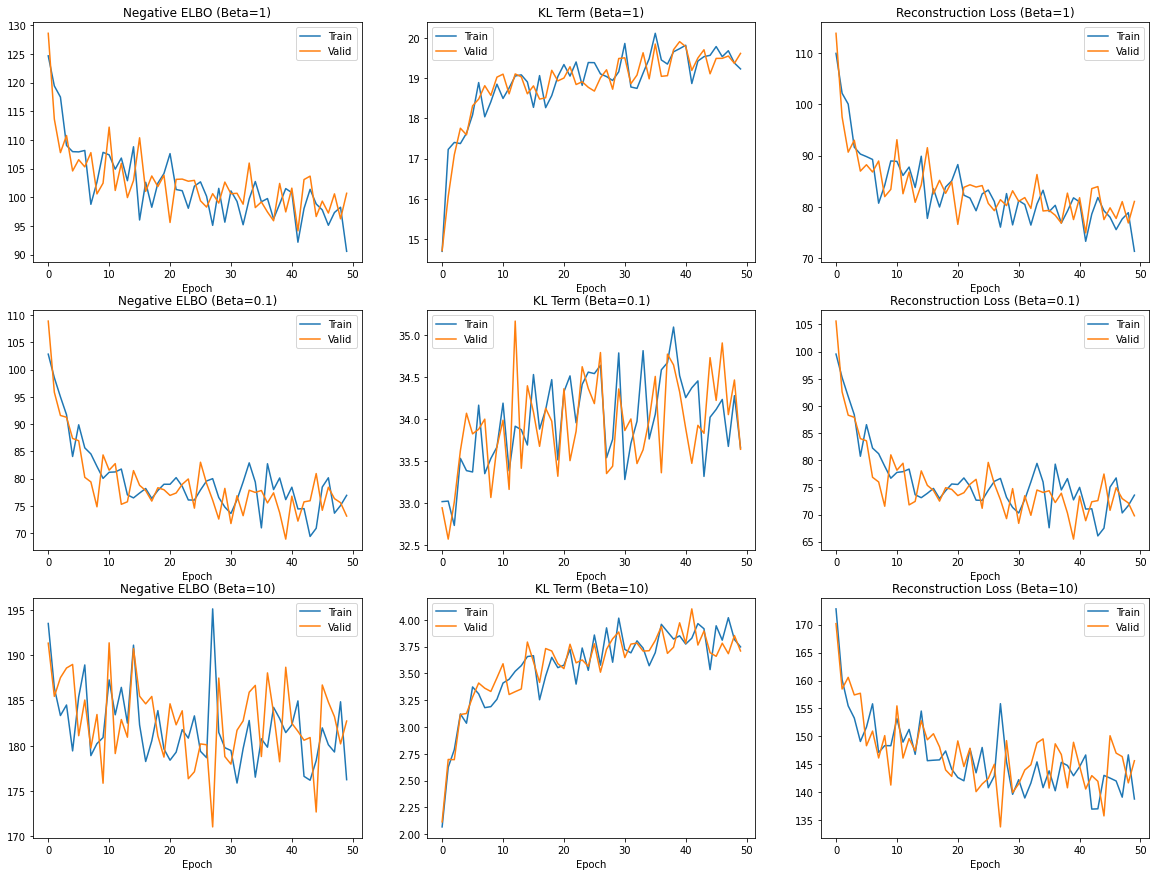

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(0,50))


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)

plt.subplot(3, 3, 1)
plt.plot(epoch,nelbo_1[0].detach().numpy())
plt.plot(epoch,nelbo_test_1[0].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Negative ELBO (Beta=1)")
plt.subplot(3, 3, 2)
plt.plot(epoch,kl_1[0].detach().numpy())
plt.plot(epoch,kl_test_1[0].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("KL Term (Beta=1)")
plt.subplot(3, 3, 3)
plt.plot(epoch,rec_1[0].detach().numpy())
plt.plot(epoch,rec_test_1[0].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("rec")
plt.title("Reconstruction Loss (Beta=1)")

plt.subplot(3, 3, 4)
plt.plot(epoch,nelbo_04[0].detach().numpy())
plt.plot(epoch,nelbo_test_04[0].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Negative ELBO (Beta=0.1)")
plt.subplot(3, 3, 5)
plt.plot(epoch,kl_04[0].detach().numpy()/0.1)
plt.plot(epoch,kl_test_04[0].detach().numpy()/0.1)
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("KL Term (Beta=0.1)")
plt.subplot(3, 3, 6)
plt.plot(epoch,rec_04[0].detach().numpy())
plt.plot(epoch,rec_test_04[0].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("rec")
plt.title("Reconstruction Loss (Beta=0.1)")

plt.subplot(3, 3, 7)
plt.plot(epoch,nelbo_10[0][0:50].detach().numpy())
plt.plot(epoch,nelbo_test_10[0][0:50].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Negative ELBO (Beta=10)")
plt.subplot(3, 3, 8)
plt.plot(epoch,kl_10[0][0:50].detach().numpy()/10)
plt.plot(epoch,kl_test_10[0][0:50].detach().numpy()/10)
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("KL Term (Beta=10)")
plt.subplot(3, 3, 9)
plt.plot(epoch,rec_10[0][0:50].detach().numpy())
plt.plot(epoch,rec_test_10[0][0:50].detach().numpy())
plt.legend(['Train','Valid'])
plt.xlabel("Epoch")
#plt.ylabel("rec")
plt.title("Reconstruction Loss (Beta=10)")

In [ ]:
def plot_reconstructed(batch_img, r0=(-5, 5), r1=(-5, 5), n=10):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = batch_img[i*10+j]
    plt.imshow(img, extent=[*r0, *r1])


In [ ]:
X=X_test[0:100][:]

X_enc_1=vae_1.enc.encode(X)
Z_sample_1=sample_gaussian(X_enc_1[0],X_enc_1[1])
Z_sample_1.shape
X_dec_1=vae_1.dec.decode(Z_sample_1)
X_dec_1.shape

torch.Size([100, 784])

# Reconstruction

Text(0.5, 1.0, 'Reconstructed Images (Beta=10)')

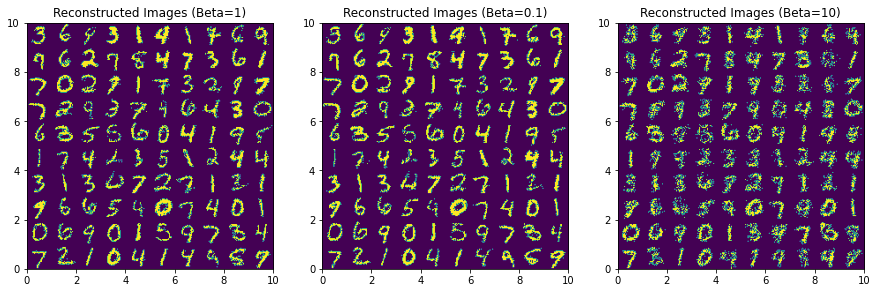

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

X=X_test[0:100][:]

X_enc_1=vae_1.enc.encode(X)
Z_sample_1=sample_gaussian(X_enc_1[0],X_enc_1[1])
logits_1=vae_1.dec.decode(Z_sample_1)
X_hat_1=torch.bernoulli(torch.sigmoid(logits_1))
rec_img_1=X_hat_1.reshape(100,28, 28).to('cpu').detach().numpy()
plt.subplot(1,3,1)
plot_reconstructed(rec_img_1, r0=(0, 10), r1=(0, 10))
plt.title("Reconstructed Images (Beta=1)")

X_enc_04=vae_04.enc.encode(X)
Z_sample_04=sample_gaussian(X_enc_04[0],X_enc_04[1])
logits_04=vae_04.dec.decode(Z_sample_04)
X_hat_04=torch.bernoulli(torch.sigmoid(logits_04))
rec_img_04=X_hat_04.reshape(100,28, 28).to('cpu').detach().numpy()
plt.subplot(1,3,2)
plot_reconstructed(rec_img_04, r0=(0, 10), r1=(0, 10))
plt.title("Reconstructed Images (Beta=0.1)")

X_enc_10=vae_10.enc.encode(X)
Z_sample_10=sample_gaussian(X_enc_10[0],X_enc_10[1])
logits_10=vae_10.dec.decode(Z_sample_10)
X_hat_10=torch.bernoulli(torch.sigmoid(logits_10))
rec_img_10=X_hat_10.reshape(100,28, 28).to('cpu').detach().numpy()
plt.subplot(1,3,3)
plot_reconstructed(rec_img_10, r0=(0, 10), r1=(0, 10))
plt.title("Reconstructed Images (Beta=10)")

# Sampling

Text(0.5, 1.0, 'Generated Images (Beta=10)')

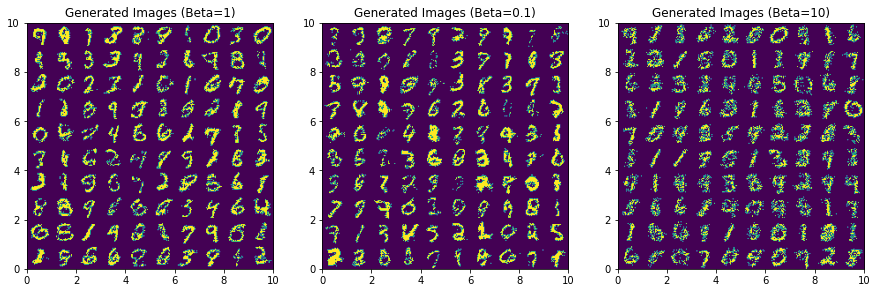

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

batch_img_1=vae_1.sample_x(100)
batch_img_04=vae_04.sample_x(100)
batch_img_10=vae_10.sample_x(100)

plt.subplot(1,3,1)
batch_img_1=batch_img_1.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(batch_img_1, r0=(0, 10), r1=(0, 10))
plt.title("Generated Images (Beta=1)")
plt.subplot(1,3,2)
batch_img_04=batch_img_04.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(batch_img_04, r0=(0, 10), r1=(0, 10))
plt.title("Generated Images (Beta=0.1)")
plt.subplot(1,3,3)
batch_img_10=batch_img_10.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(batch_img_10, r0=(0, 10), r1=(0, 10))
plt.title("Generated Images (Beta=10)")

# Disentangled Analysis with BVAE(Beta=4)

In [ ]:
vae_4 = VAE(z_dim=z,Beta=4).to(device)
optimizer = optim.Adam(vae_4.parameters(), lr=learning_rate)
nelbo_4=torch.zeros(1,50)
kl_4=torch.zeros(1,50)
rec_4=torch.zeros(1,50)
nelbo_test_4=torch.zeros(1,50)
kl_test_4=torch.zeros(1,50)
rec_test_4=torch.zeros(1,50)
for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae_4.loss(xu)
        nelbo_4[0][i]=loss
        kl_4[0][i]=summaries['gen/kl_z']
        rec_4[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = vae_4.loss(xu_test)
        nelbo_test_4[0][i]=loss_test
        kl_test_4[0][i]=summaries_test['gen/kl_z']
        rec_test_4[0][i]=summaries_test['gen/rec']


  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(162.4332, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(24.7214, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(137.7119, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:08<06:38,  8.13s/it]

nelbo:  tensor(155.3388, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(28.8031, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(126.5357, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:16<06:32,  8.17s/it]

nelbo:  tensor(159.3071, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(31.1621, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(128.1450, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:25<06:45,  8.63s/it]

nelbo:  tensor(143.7409, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(31.4370, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(112.3039, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:33<06:28,  8.45s/it]

nelbo:  tensor(156.3527, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(33.6924, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(122.6603, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:41<06:17,  8.39s/it]

nelbo:  tensor(152.3386, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(34.8167, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(117.5219, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:50<06:06,  8.34s/it]

nelbo:  tensor(150.0453, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.4054, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(114.6399, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [00:58<05:57,  8.30s/it]

nelbo:  tensor(148.9386, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.4951, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(113.4435, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:06<05:46,  8.24s/it]

nelbo:  tensor(140.4948, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(33.9153, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.5796, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:14<05:36,  8.21s/it]

nelbo:  tensor(147.9477, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.5183, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(111.4294, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:22<05:29,  8.23s/it]

nelbo:  tensor(144.4997, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.1791, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(108.3206, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:31<05:20,  8.23s/it]

nelbo:  tensor(151.5186, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.9542, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(114.5643, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:39<05:17,  8.36s/it]

nelbo:  tensor(150.9280, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.3103, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(113.6177, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [01:48<05:09,  8.36s/it]

nelbo:  tensor(145.8244, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.9387, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(109.8857, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [01:56<04:58,  8.29s/it]

nelbo:  tensor(148.9787, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.3229, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(111.6558, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:04<04:48,  8.25s/it]

nelbo:  tensor(145.0808, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.1319, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(108.9489, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:12<04:38,  8.19s/it]

nelbo:  tensor(142.6685, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.4194, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.2491, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:20<04:29,  8.16s/it]

nelbo:  tensor(145.3526, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.1581, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(109.1945, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:28<04:20,  8.15s/it]

nelbo:  tensor(143.4301, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.9800, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(105.4502, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [02:36<04:12,  8.13s/it]

nelbo:  tensor(141.4041, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.9109, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.4932, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [02:44<04:03,  8.11s/it]

nelbo:  tensor(144.1065, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.8660, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.2405, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [02:52<03:54,  8.10s/it]

nelbo:  tensor(140.0809, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.5911, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.4898, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:01<03:47,  8.14s/it]

nelbo:  tensor(140.8863, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(35.7922, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(105.0941, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:09<03:39,  8.13s/it]

nelbo:  tensor(144.7148, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.2239, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.4909, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:17<03:30,  8.10s/it]

nelbo:  tensor(145.5828, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.8290, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(107.7538, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [03:25<03:22,  8.08s/it]

nelbo:  tensor(146.5592, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(40.4432, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.1160, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [03:33<03:14,  8.09s/it]

nelbo:  tensor(141.1518, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(36.9928, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(104.1590, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [03:41<03:06,  8.12s/it]

nelbo:  tensor(136.3290, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.1849, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(99.1441, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [03:49<02:59,  8.15s/it]

nelbo:  tensor(139.5320, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.5465, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.9856, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [03:58<02:51,  8.15s/it]

nelbo:  tensor(135.5099, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.9307, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(96.5792, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:06<02:42,  8.14s/it]

nelbo:  tensor(147.1447, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.7884, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(108.3563, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:14<02:33,  8.09s/it]

nelbo:  tensor(145.5359, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.2725, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(107.2635, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:22<02:25,  8.08s/it]

nelbo:  tensor(145.5656, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.6886, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(106.8770, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [04:30<02:17,  8.06s/it]

nelbo:  tensor(138.1911, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.9136, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(100.2775, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [04:38<02:08,  8.05s/it]

nelbo:  tensor(142.9228, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.6499, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.2730, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [04:46<02:00,  8.05s/it]

nelbo:  tensor(140.4711, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.1691, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(102.3020, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [04:54<01:52,  8.05s/it]

nelbo:  tensor(143.4704, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.2398, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(104.2306, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:02<01:44,  8.06s/it]

nelbo:  tensor(137.3061, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.7855, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(99.5206, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:10<01:37,  8.09s/it]

nelbo:  tensor(139.0097, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.8131, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(100.1966, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:18<01:28,  8.07s/it]

nelbo:  tensor(140.2990, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.3718, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.9272, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [05:26<01:20,  8.10s/it]

nelbo:  tensor(149.6647, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.6213, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(110.0434, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [05:35<01:14,  8.29s/it]

nelbo:  tensor(142.9585, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.2599, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.6986, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [05:43<01:05,  8.23s/it]

nelbo:  tensor(139.0735, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.4059, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.6676, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [05:51<00:57,  8.19s/it]

nelbo:  tensor(141.6042, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.6472, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.9569, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [05:59<00:49,  8.17s/it]

nelbo:  tensor(140.3565, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.3549, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.0015, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:07<00:40,  8.15s/it]

nelbo:  tensor(141.7192, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.8802, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(103.8390, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [06:16<00:32,  8.13s/it]

nelbo:  tensor(146.7219, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(39.7157, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(107.0062, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [06:24<00:24,  8.13s/it]

nelbo:  tensor(139.4691, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.7263, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.7428, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [06:32<00:16,  8.18s/it]

nelbo:  tensor(140.1221, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(38.7380, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(101.3840, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [06:40<00:08,  8.21s/it]

nelbo:  tensor(139.8721, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(37.6901, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(102.1820, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [06:48<00:00,  8.18s/it]


## dimension 0

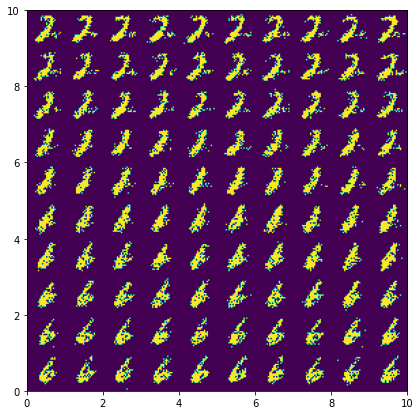

In [ ]:

a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,0]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 2

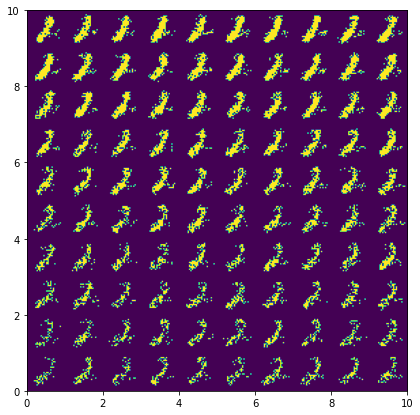

In [ ]:
# dimension 2
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,2]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 3

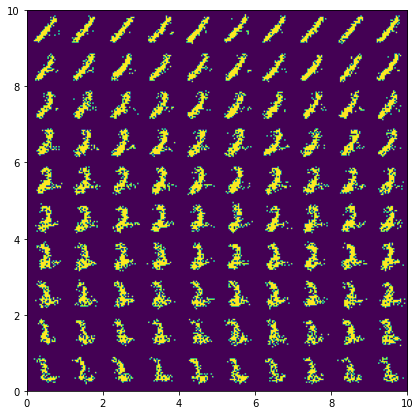

In [ ]:
# dimension 3
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,3]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 5

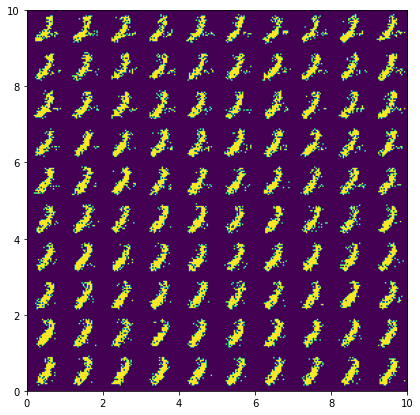

In [ ]:
# dimension 5
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,5]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 7

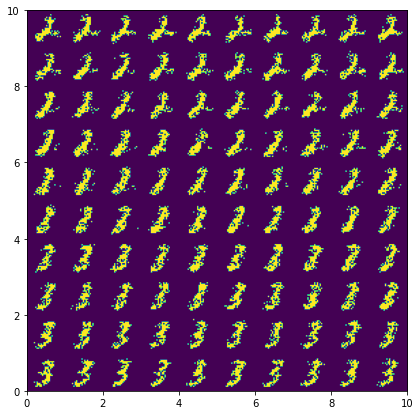

In [ ]:
# dimension 7
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,7]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 8

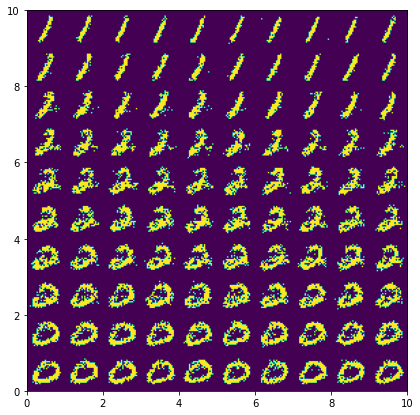

In [ ]:
# dimension 8
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,8]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))

## dimension 9

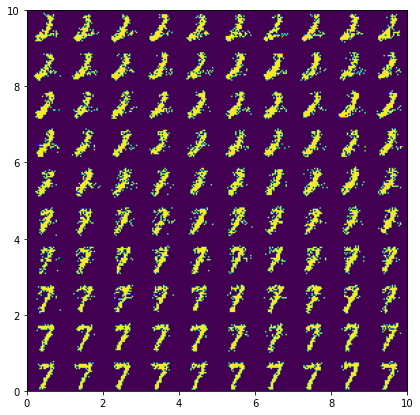

In [ ]:
# dimension 9
a=torch.ones(1).cuda()
a=a.expand(100, 10).clone()
b=torch.linspace(-2.5, 2.5 , steps=100).cuda()
a[:,9]=b
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)
logit_a=vae_4.dec.decode(a)
x_out=torch.bernoulli(torch.sigmoid(logit_a))
x_out=x_out.reshape(100,28, 28).to('cpu').detach().numpy()
plot_reconstructed(x_out, r0=(0, 10), r1=(0, 10))